# Santa 20 Kaggle competition

See description at [our github](https://github.com/RobRomijnders/santa20)

Part of Christmas holiday project by Vincent Warmerdam and Rob Romijnders.

Feel free to use this code. Github repo has the appropriate MIT license.

In [1]:
# Install the Kaggle Environment

%pip install kaggle_environments

     |████████████████████████████████| 112kB 5.5MB/s 
     |████████████████████████████████| 61kB 7.5MB/s 
ERROR: nbclient 0.5.1 has requirement jupyter-client>=6.1.5, but you'll have jupyter-client 5.3.5 which is incompatible.
  Found existing installation: jsonschema 2.6.0
    Uninstalling jsonschema-2.6.0:
      Successfully uninstalled jsonschema-2.6.0


In [2]:
from pprint import pprint 
from typing import Tuple

import copy
import matplotlib.pylab as plt 
import numpy as np
import random

class Bots:
    def __init__(self, 
                 prior: Tuple[int, int] = (10, 10), 
                 decay: float = 1.0, 
                 arm_fixed: int = 0):
        # Prototype distribution for each arm
        self.distr = {"prior": prior, "data": []}

        # Put all arms in a dict (to be initialized at first call)
        self.arms_beliefs = None

        # Decay factor for arm beliefs
        self.decay = decay

        # Lists to log the actions taken
        self.actions_ours = []
        self.actions_theirs = []

        self.counts = {}

        # Fixed arm (used for debugging)
        self.arm_fixed = arm_fixed

        # Datastructures to log the rewards
        self.rewards_prev = 0
        self.rewards = []

        # Decay coefficients for the parameters of our distributions
        num_steps_total = 2000
        self.coeffs_all = np.array([self.decay**(num_steps_total - i - 1) 
                                    for i in range(num_steps_total)])

    def log_obs(self, obs):
        """Log the observations."""
        if len(obs.lastActions) > 0:
          self.rewards.append(obs.reward - self.rewards_prev)
          self.actions_ours.append(obs.lastActions[obs.agentIndex])
          self.actions_theirs.append(obs.lastActions[1 if obs.agentIndex == 0 else 0])

          # Update total reward
          self.rewards_prev = obs.reward

    def random_agent(self, observation, configuration):
        """Agent for taking a random action."""
        self.log_obs(observation)
        return random.randrange(configuration.banditCount)

    def fixed_agent(self, observation, configuration):
        """Agent for taking a fixed action."""
        self.log_obs(observation)

        if self.arms_beliefs is None:
            # Init priors on the first step
            self.arms_beliefs = {k: copy.deepcopy(self.distr) for k in 
                                 range(configuration.banditCount)}
        else:
            prev_action = self.actions_ours[-1]
            if len(self.rewards) > 0:
                self.arms_beliefs[prev_action]['data'].append(self.rewards[-1])

        # For debugging: take a different, fixed, action after first half
        if observation.step > 1000:
          return self.arm_fixed + 1
        return self.arm_fixed  # Fixed action

    def update_beliefs(self, observation, configuration):
        """Update the beliefs for each arm.
        
        .update_beliefs() should be called after .log_obs() so that the list
        of rewards has been updated for this round.        
        """
        if self.arms_beliefs is None:
            # Init priors on the first step
            self.arms_beliefs = {k: copy.deepcopy(self.distr) 
                                 for k in range(configuration.banditCount)}
        else:
            prev_action = self.actions_ours[-1]
            if len(self.rewards) > 0:
                self.arms_beliefs[prev_action]['data'].append(self.rewards[-1])

    def agent_thompson(self, observation, configuration):
        """Thompson sampling without decay."""
        self.log_obs(observation)
        self.update_beliefs(observation, configuration)

        pvals = []
        for key, distr in self.arms_beliefs.items():
            # Observed counts
            observed_a = sum(distr["data"])
            observed_b = len(distr["data"]) - observed_a

            # Add prior counts
            beta_a = observed_a + distr["prior"][0]
            beta_b = observed_b + distr["prior"][1]

            # Draw p for Bernoulli distribution from Beta distribution
            pvals.append((key, np.random.beta(beta_a, beta_b)))

        # Take the action with highest p
        return max(pvals, key=lambda d: d[1])[0]

    def agent_thompson_decay(self, observation, configuration):
        """Thompson sampling with decay."""
        self.log_obs(observation)
        self.update_beliefs(observation, configuration)

        pvals = []
        for key, distr in self.arms_beliefs.items():
            # Observed counts
            data = np.array(distr["data"])
            num_steps = len(data)

            beta_a = distr["prior"][0]
            beta_b = distr["prior"][1]

            if num_steps > 0:
                # Slice decay coefficients such that coeffs[-1] is always 1.0
                coeffs = self.coeffs_all[-num_steps:] 

                # Multiply 'coeffs' with 'data' to apply more decay to earlier
                # observations.
                beta_a += np.sum(coeffs * data)
                beta_b += np.sum(coeffs * (1-data))

            # Draw p for Bernoulli distribution from Beta distribution
            pvals.append((key, np.random.beta(beta_a, beta_b)))

        # Take the action with highest p
        return max(pvals, key=lambda d: d[1])[0]

In [3]:
from kaggle_environments import make
import tqdm

# Each observation has keys: 
# ['agentIndex', 'lastActions', 'remainingOverageTime', 'reward', 'step']

bot1, bot2 = Bots(prior=(2,10), decay=1.0), Bots(prior=(1, 1), decay=0.9)
env = make("mab", debug=True)
res = env.run([bot1.agent_thompson, bot2.agent_thompson_decay])

Loading environment football failed: No module named 'gfootball'


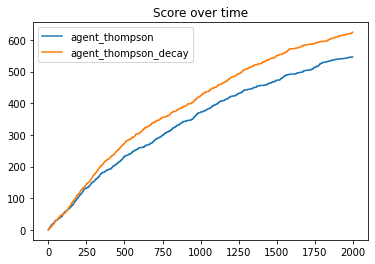

In [5]:
plt.figure()
plt.plot(np.cumsum(bot1.rewards), label="agent_thompson")
plt.plot(np.cumsum(bot2.rewards), label="agent_thompson_decay")
plt.legend()
plt.title("Score over time");

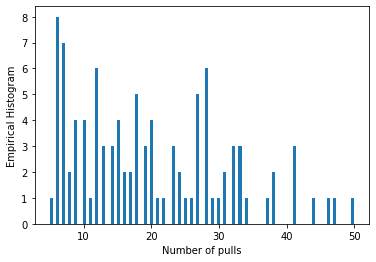

In [7]:
plt.figure()
plt.hist([len(d["data"]) for d in bot2.arms_beliefs.values()], bins=100)
plt.xlabel("Number of pulls")
plt.ylabel("Empirical Histogram")
plt.show()

# Plots for debugging
Uncomment at your own risk :)

In [8]:
# print(f"Number of arms found {len(b2.arms_beliefs)}")

# bonuses = []

# for num_arm in [ARM_FIXED, ARM_FIXED+1]:
#   # Rewards observed for arm 'num_arm'
#   rewards = b2.arms_beliefs[num_arm]["h"][1:]  # Skip the prior at index 0

#   reward_cumulative = np.cumsum(rewards)
#   num_acted = len(reward_cumulative)  # Number of times this arm was taken as action

#   # Global expected reward rate
#   reward_rate = np.mean(rewards)
#   reward_total = np.sum(rewards)
#   alpha = 0.5
#   p0 = reward_total * ( 1 - alpha) / (1 - alpha ** num_acted)
#   p0 = min((p0, 1.))

#   reward_cumulative_expected = [reward_rate * i for i in range(1, num_acted + 1)]
#   reward_cumulative_exponential = np.cumsum([p0 * alpha ** t for t in range(num_acted)])

#   bonus = np.mean((reward_cumulative - reward_cumulative_exponential) / reward_total)
#   bonuses.append(bonus)

#   plt.figure()
#   plt.title(f"Arm {num_arm} - early bonus {bonus:4.2f}")
#   plt.plot(reward_cumulative, label="Empirical")
#   plt.plot(reward_cumulative_expected, label="Expected alpha=1")
#   # plt.plot(reward_cumulative_exponential, label="Expected alpha=alpha")
#   # plt.ylim([0, num_acted])
#   plt.xlabel(f"Num acted")
#   plt.ylabel("Cumulative reward")
#   plt.legend()

In [9]:
# plt.figure()
# plt.title(f"Mean bonus {np.mean(bonuses):5.2f}")
# plt.hist(bonuses)
# plt.xlabel("Bonus value")
# plt.ylabel("Empirical histogram")
# plt.show()

In [10]:
def best_of_n(agents, n=20):
    """Calculate best agent averaged in n runs."""

    env = make("mab", debug=True)

    # Lists for accumulating data
    wins = []
    p1_scores = []
    p2_scores = []

    for i in tqdm.tqdm(range(n)):
        # Construct new instances of agent
        agent1 = agents[0]()
        agent2 = agents[1]()

        # Run in environment
        env.run([agent1, agent2])
        p1_score = env.steps[-1][0]['reward']
        p2_score = env.steps[-1][1]['reward']

        p1_scores.append(p1_score)
        p2_scores.append(p2_score)

        env.reset()
        wins.append(p1_score > p2_score)
        print(f"Round {i+1}: {p1_score} - {p2_score}")

    print(f"Agent 1 won: {round(sum(wins)/len(wins), ndigits=4)}")

    print("Scores for each player:")
    print(p1_scores)
    print(p2_scores)

best_of_n(agents=[
                  lambda : Bots(prior=(1,1), decay=1.0).agent_thompson,
                  lambda : Bots(prior=(1,1), decay=0.8).agent_thompson_decay
])

  5%|▌         | 1/20 [00:15<04:47, 15.13s/it]

Round 1: 616 - 633


 10%|█         | 2/20 [00:29<04:30, 15.03s/it]

Round 2: 652 - 665


 15%|█▌        | 3/20 [00:44<04:14, 14.98s/it]

Round 3: 659 - 679


 20%|██        | 4/20 [00:59<03:58, 14.91s/it]

Round 4: 580 - 635


 25%|██▌       | 5/20 [01:14<03:44, 14.94s/it]

Round 5: 642 - 643


 30%|███       | 6/20 [01:29<03:29, 14.95s/it]

Round 6: 699 - 642


 35%|███▌      | 7/20 [01:44<03:14, 14.97s/it]

Round 7: 667 - 651


 40%|████      | 8/20 [01:59<02:59, 14.96s/it]

Round 8: 648 - 585


 45%|████▌     | 9/20 [02:14<02:44, 14.95s/it]

Round 9: 656 - 663


 50%|█████     | 10/20 [02:29<02:29, 14.98s/it]

Round 10: 618 - 627


 55%|█████▌    | 11/20 [02:44<02:15, 15.05s/it]

Round 11: 585 - 616


 60%|██████    | 12/20 [02:59<02:00, 15.06s/it]

Round 12: 573 - 641


 65%|██████▌   | 13/20 [03:14<01:44, 14.97s/it]

Round 13: 600 - 612


 70%|███████   | 14/20 [03:29<01:29, 14.91s/it]

Round 14: 606 - 567


 75%|███████▌  | 15/20 [03:44<01:14, 14.97s/it]

Round 15: 608 - 609


 80%|████████  | 16/20 [03:59<00:59, 14.96s/it]

Round 16: 538 - 567


 85%|████████▌ | 17/20 [04:14<00:44, 14.98s/it]

Round 17: 652 - 588


 90%|█████████ | 18/20 [04:28<00:29, 14.87s/it]

Round 18: 637 - 633


 95%|█████████▌| 19/20 [04:44<00:14, 14.95s/it]

Round 19: 669 - 641


100%|██████████| 20/20 [04:59<00:00, 14.96s/it]

Round 20: 631 - 687
Agent 1 won: 0.35
Scores for each player:
[616, 652, 659, 580, 642, 699, 667, 648, 656, 618, 585, 573, 600, 606, 608, 538, 652, 637, 669, 631]
[633, 665, 679, 635, 643, 642, 651, 585, 663, 627, 616, 641, 612, 567, 609, 567, 588, 633, 641, 687]


636, 642, 648, 721, 562, 653, 626, 664, 658, 635, 627, 626, 676, 714, 677, 578, 548, 665, 655, 673, 

In [ ]:
# 0.9
data = [756, 722, 708, 714, 689, 603, 568, 698, 706, 688, 640, 653, 706, 667, 635, 723, 609, 721, 747, 651,]
print(f"Mean +- std: {np.mean(data):5.2f} +- {np.std(data):5.2f}")

# 0.8
data = [661, 648, 724, 688, 687, 720, 669, 708, 572, 538, 658, 650, 646, 758, 622, 676, 715, 623, 657, 729,]
print(f"Mean +- std: {np.mean(data):5.2f} +- {np.std(data):5.2f}")


# 0.7
data = [600, 707, 639, 741, 664, 621, 642, 700, 654, 639, 753, 670, 686, 610, 589, 753, 717, 718, 591, 691,]
print(f"Mean +- std: {np.mean(data):5.2f} +- {np.std(data):5.2f}")

# 0.2
data = [636, 642, 648, 721, 562, 653, 626, 664, 658, 635, 627, 626, 676, 714, 677, 578, 548, 665, 655, 673, ]
print(f"Mean +- std: {np.mean(data):5.2f} +- {np.std(data):5.2f}")

# 0.8 with opponent with prior (1,1)
data = [652, 653, 549, 609, 569, 629, 614, 624, 573, 619, 596, 622, 589, 690, 676, 623, 667, 571, 665, 628]
print(f"Mean +- std: {np.mean(data):5.2f} +- {np.std(data):5.2f}")
